## Data Wrangling

Table of contents

- Gathering
  - Twitter archive enhanced
  - Tweet Image predictions
  - Tweet Json Data using tweepy
- Assesing
  - Quality Issues
  - Tidyness Issues
- Cleaning

### Gathering

#### Twitter archive enhanced

This data is located in a file named `twitter-archive-enhanced.csv`

In [1]:
import pandas as pd
import requests
import io
import tweepy
import os
import json
import time

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for jupyter notebooks to enable inline plotting
%matplotlib inline

In [2]:
twitter_archive_enhanced = pd.read_csv("twitter-archive-enhanced.csv")
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Tweet image predictions

This file contains predictions genrated by a neural network. The file is hosted [here] (https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv) (Note that the seperator here is `\t`)

In [3]:
image_predictions_file = "image_predictions.tsv"
predictions_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
with open(image_predictions_file, "w") as f:
    f.write(requests.get(predictions_url).content.decode('utf-8'))

tweet_image_predictions = pd.read_csv(image_predictions_file, sep="\t")
tweet_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Tweet json data using tweepy

This is saved in a file named `tweet_json.txt` where each line corresponds to a single tweet data in json format. The json object has following fields:
- tweet ID
- retweet count
- favorite count

In [4]:
# TODO : DELETE Secrets
os.environ["API_KEY"] = ""
os.environ["API_SECRET_KEY"] = ""
os.environ["ACCESS_TOKEN"] = ""
os.environ["ACCESS_TOKEN_SECRET"] = ""

In [ ]:
consumer_key = os.environ["API_KEY"]
consumer_secret = os.environ["API_SECRET_KEY"]
access_token = os.environ["ACCESS_TOKEN"]
access_secret = os.environ["ACCESS_TOKEN_SECRET"]


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit_notify = True, wait_on_rate_limit = True)

# Create a file named `tweet_json.txt` to save all the tweets. Each tweet goes on a new line.
tweet_errors = {}
with open("tweet_json.txt","w+") as f:
    for tweet_id in twitter_archive_enhanced.tweet_id.unique():
        start = time.time()
        try:
            tweet_data = api.get_status(tweet_id, tweet_mode='extended')
        except Exception as e:
            print("error fetching tweet {} : {}".format(tweet_id, str(e)))
            tweet_errors["{}".format(tweet_id)] = e
        json_tweet_data = json.dumps(tweet_data._json)
        f.write(json_tweet_data)
        f.write('\n')
        end = time.time()
        print("Took {:0.2f}s for {} \t".format(end-start, tweet_id), end='')

with open("tweet_json_errors.txt","w+") as f:
    f.write(json.dumps(tweet_errors, indent = 2))

In [5]:
# list of lists. each element contains three columns : tweet_id, fav count, retweet count
tweets = []
with open("tweet_json.txt", "r") as f:
    for line in f:
        stripped_line = line.strip()
        tweet_json = json.loads(stripped_line)
        tweets.append([tweet_json["id"], tweet_json["favorite_count"], tweet_json["retweet_count"]])
print("loaded {} tweets", len(tweets))
tweepy_status_data = pd.DataFrame(tweets, columns = ['tweet_id', 'favorite_count', 'retweet_count'])
tweepy_status_data.head(2)
tweepy_status_data.info()

loaded {} tweets 2356
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null int64
favorite_count    2356 non-null int64
retweet_count     2356 non-null int64
dtypes: int64(3)
memory usage: 55.3 KB


### Assessing the data

##### Quality Issues 
1. `twitter_archive_enhanced` has 181 retweets and 78 replies which can be dropped. (This is evident from `info()` call)
2. `twitter_archive_enhanced` has 2356 rows while the `tweet_image_predictions` has 2075 rows. This could be probably because of the missing images, retweets etc.,
3. Not all dogs have valid names. For example:
   ```bash
   > twitter_archive_enhanced.name.value_counts()
   None        745
   a            55
   ```
   This is not a serious quality issue but is definitely something to be aware of during our analysis.
4. Only 2333 entires have a valid denominator of 10. Rest have a non standard value.
5. The range of rating numerator varies from 0 to 1776 which is very strange even considering that we have a rating convention where numerator can be greater than denominator.
6. The [Dogitionary](https://video.udacity-data.com/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png) categorizes the dogs in to six categories where as the dataset has only four categories.
7. There are 1976 rows where the values for all the four columns `doggo`, `floofer`, `pupper`, and `puppo` are None. These dogs could be belonging to other two missing categories or were not rated. This data is missing.
8. Columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_user_id`, `retweeted_status_id` have a float datatype but they could have been strings which would have made it easier for parsing.
9. `tweet_id` is integer. String would have been appropriate as we cannot perform any operations on `tweet_id` column. This is applicable for both `twitter_archive_enhanced` and `tweet_image_predictions` datasets.
10. We can change the timestamp field to be a date object instead of string. This is not really something that could be fixed in the dataset because csv file would only support primitive data types. We don't need to handle this in here because our final result is again storing the dataset to a csv file.

##### Tidyness issues
1. The choice of datatype for the columns `doggo`, `floofer`, `pupper`, `puppo` is not chosen appropriately. Instead of writing `None` as empty string, if this were a boolean value it would have been easier to process the data. Even more, we don't need multiple columns for the categories. Just a single column that has a string value containing one of the dog categories would have sufficed.
2. We have three columns p1_dog, p2_dog and p3_dog and each of those are boolean values that predict if the predictions is a dog or not. Since are only concerned about dogs, we can consolidate these columns in to one.
3. `twitter_archive_enhanced` and `tweet_image_predictions` could have been in single dataset instead of two.

In [6]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
twitter_archive_enhanced.name.value_counts().head(3)

None       745
a           55
Charlie     12
Name: name, dtype: int64

In [8]:
twitter_archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [9]:
twitter_archive_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [10]:
twitter_archive_enhanced.query("doggo == 'None'").query("floofer == 'None'").query("pupper == 'None'").query("puppo == 'None'").count()

tweet_id                      1976
in_reply_to_status_id           70
in_reply_to_user_id             70
timestamp                     1976
source                        1976
text                          1976
retweeted_status_id            145
retweeted_status_user_id       145
retweeted_status_timestamp     145
expanded_urls                 1923
rating_numerator              1976
rating_denominator            1976
name                          1976
doggo                         1976
floofer                       1976
pupper                        1976
puppo                         1976
dtype: int64

In [11]:
twitter_archive_enhanced.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [12]:
tweet_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Cleaning the data

Lets address the quality concerns first and then we can tidy up our data. As a first step, lets merge all our dataframes in to a single master dataframe. This also addresses Tidyness issue #2

In [13]:
# Merge the initial archive given to us with the json data fetched using the twitter API
archive_enriched_df = pd.merge(twitter_archive_enhanced, tweepy_status_data, on=['tweet_id','tweet_id'], how='left')
archive_enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 19 columns):
tweet_id                      2381 non-null int64
in_reply_to_status_id         79 non-null float64
in_reply_to_user_id           79 non-null float64
timestamp                     2381 non-null object
source                        2381 non-null object
text                          2381 non-null object
retweeted_status_id           182 non-null float64
retweeted_status_user_id      182 non-null float64
retweeted_status_timestamp    182 non-null object
expanded_urls                 2322 non-null object
rating_numerator              2381 non-null int64
rating_denominator            2381 non-null int64
name                          2381 non-null object
doggo                         2381 non-null object
floofer                       2381 non-null object
pupper                        2381 non-null object
puppo                         2381 non-null object
favorite_count                23

Note that while we have 2381 rows in the original dataset we only have 2356 non null values for `favorite_count` and `retweet_count` because we were unable to fetch the json data for all the tweets using the twitter API. The error codes are listed in a file named `tweet_json_errors.txt` for reference on failures.

Now, we can merge this new dataframe with the image predictions dataframe.

In [14]:
df = pd.merge(archive_enriched_df, tweet_image_predictions, on=['tweet_id','tweet_id'], how='left')
df.to_csv("raw_twitter_archive_master.csv", encoding='utf-8', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 30 columns):
tweet_id                      2381 non-null int64
in_reply_to_status_id         79 non-null float64
in_reply_to_user_id           79 non-null float64
timestamp                     2381 non-null object
source                        2381 non-null object
text                          2381 non-null object
retweeted_status_id           182 non-null float64
retweeted_status_user_id      182 non-null float64
retweeted_status_timestamp    182 non-null object
expanded_urls                 2322 non-null object
rating_numerator              2381 non-null int64
rating_denominator            2381 non-null int64
name                          2381 non-null object
doggo                         2381 non-null object
floofer                       2381 non-null object
pupper                        2381 non-null object
puppo                         2381 non-null object
favorite_count                23

In [15]:
df.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
195,856282028240666624,NaN,NaN,2017-04-23 23:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Cermet, Paesh, and Morple. They are ab...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856282028...,...,4.0,Chihuahua,0.876543,True,Italian_greyhound,0.032962,True,Cardigan,0.020776,True
174,859851578198683649,NaN,NaN,2017-05-03 19:26:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Trooper. He picks pup recyclables that ha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859851578...,...,4.0,Labrador_retriever,0.899086,True,golden_retriever,0.047091,True,kuvasz,0.023206,True


Now that we have a single dataframe that has all our datasets, we can start with the cleaning process. Let's addrress the missing values first.

Rows with non null column values for the following columns can be dropped as they are retweets which we are not interested in:
- `retweeted_status_id`
- `retweeted_status_user_id`
- `retweeted_status_timestamp`

Same applies for following columns which indicates if a row is corresponding to a reply. We do not need replies as well:

- `in_reply_to_user_id`
- `in_reply_to_status_id`


In [16]:
df = df[df.retweeted_status_id.isnull()]

assert df.retweeted_status_id.value_counts().empty
assert df.retweeted_status_user_id.value_counts().empty
assert df.retweeted_status_timestamp.value_counts().empty

df.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 0 to 2380
Data columns (total 27 columns):
tweet_id                 2199 non-null int64
in_reply_to_status_id    79 non-null float64
in_reply_to_user_id      79 non-null float64
timestamp                2199 non-null object
source                   2199 non-null object
text                     2199 non-null object
expanded_urls            2141 non-null object
rating_numerator         2199 non-null int64
rating_denominator       2199 non-null int64
name                     2199 non-null object
doggo                    2199 non-null object
floofer                  2199 non-null object
pupper                   2199 non-null object
puppo                    2199 non-null object
favorite_count           2192 non-null float64
retweet_count            2192 non-null float64
jpg_url                  2017 non-null object
img_num                  2017 non-null float64
p1                       2017 non-null object
p1_conf              

In [17]:
df = df[df.in_reply_to_user_id.isnull()]

assert df.in_reply_to_user_id.value_counts().empty
assert df.in_reply_to_status_id.value_counts().empty

df.drop(columns=['in_reply_to_user_id', 'in_reply_to_status_id'], axis=1, inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2380
Data columns (total 25 columns):
tweet_id              2120 non-null int64
timestamp             2120 non-null object
source                2120 non-null object
text                  2120 non-null object
expanded_urls         2117 non-null object
rating_numerator      2120 non-null int64
rating_denominator    2120 non-null int64
name                  2120 non-null object
doggo                 2120 non-null object
floofer               2120 non-null object
pupper                2120 non-null object
puppo                 2120 non-null object
favorite_count        2113 non-null float64
retweet_count         2113 non-null float64
jpg_url               1993 non-null object
img_num               1993 non-null float64
p1                    1993 non-null object
p1_conf               1993 non-null float64
p1_dog                1993 non-null object
p2                    1993 non-null object
p2_conf               1993 non-n

After getting rid of all the retweets and replies we still have 120 rows with an empty value for `jpg_url` column. As this is a mandatory field, we can drop the rows for which the value of `jpg_url` is null.

In [18]:
df = df[~df.jpg_url.isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2380
Data columns (total 25 columns):
tweet_id              1993 non-null int64
timestamp             1993 non-null object
source                1993 non-null object
text                  1993 non-null object
expanded_urls         1993 non-null object
rating_numerator      1993 non-null int64
rating_denominator    1993 non-null int64
name                  1993 non-null object
doggo                 1993 non-null object
floofer               1993 non-null object
pupper                1993 non-null object
puppo                 1993 non-null object
favorite_count        1986 non-null float64
retweet_count         1986 non-null float64
jpg_url               1993 non-null object
img_num               1993 non-null float64
p1                    1993 non-null object
p1_conf               1993 non-null float64
p1_dog                1993 non-null object
p2                    1993 non-null object
p2_conf               1993 non-n

We still have 7 entries that have NaN values for favorite_count and retweet_count. These could have come from the errors caused during `get_status` call. Let's drop these as well.

In [19]:
df = df[df.retweet_count.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 2380
Data columns (total 25 columns):
tweet_id              1986 non-null int64
timestamp             1986 non-null object
source                1986 non-null object
text                  1986 non-null object
expanded_urls         1986 non-null object
rating_numerator      1986 non-null int64
rating_denominator    1986 non-null int64
name                  1986 non-null object
doggo                 1986 non-null object
floofer               1986 non-null object
pupper                1986 non-null object
puppo                 1986 non-null object
favorite_count        1986 non-null float64
retweet_count         1986 non-null float64
jpg_url               1986 non-null object
img_num               1986 non-null float64
p1                    1986 non-null object
p1_conf               1986 non-null float64
p1_dog                1986 non-null object
p2                    1986 non-null object
p2_conf               1986 non-n

From above info() call, we can see that each column in our dataset has exactly 1986 values. 

Lets address the broad range numerator and denominator values. Look at the tweets whose denominators are not equal to 10 and see the actual tweets.

In [20]:
non_standard_numerators = df.query("rating_numerator > 20")[["tweet_id", "rating_numerator", "text"]]
non_standard_numerators

,tweet_id,rating_numerator,text
449,820690176645140481,84,The floofs have been released I repeat the flo...
533,810984652412424192,24,Meet Sam. She smiles 24/7 &amp; secretly aspir...
713,786709082849828864,75,"This is Logan, the Chow who lived. He solemnly..."
782,778027034220126208,27,This is Sophie. She's a Jubilant Bush Pupper. ...
925,758467244762497024,165,Why does this never happen at my front door......
1003,749981277374128128,1776,This is Atticus. He's quite simply America af....
1144,731156023742988288,204,Say hello to this unbelievably well behaved sq...
1226,716439118184652801,50,This is Bluebert. He just saw that both #Final...
1252,713900603437621249,99,Happy Saturday here's 9 puppers on a bench. 99...
1278,710658690886586372,80,Here's a brigade of puppers. All look very pre...


In [21]:
pd.set_option('display.max_colwidth', -1)
non_standard_denominators = df.query("rating_denominator != 10")[["tweet_id", "rating_denominator", "text"]]
non_standard_denominators

,tweet_id,rating_denominator,text
449,820690176645140481,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
533,810984652412424192,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
925,758467244762497024,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1092,740373189193256964,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1144,731156023742988288,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1189,722974582966214656,20,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1226,716439118184652801,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1252,713900603437621249,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1278,710658690886586372,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1298,709198395643068416,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"


Looking at above tweets, various strings such as `7/11`, `9/11` etc., were misinterpreted. And also some of the ratings involved decimal places in the numerators (like `9.75/10`). Some of the values such as `204/170` and `144/120` correspond to photos with multiple dogs in them. 


We can perform some manual cleanup for some of these entries and we can drop the rows for others. Since these entries only make up < 0.01% of the entire dataset and the ratings are one of the key aspects of this dataset, we can safely drop the inaccurate entries to faciliate good analysis.

##### Manual cleanup of numerator and denominator ratings.

We can round up (or round down) for some of the above entries and correct the misinterpreted entries (like 7/11). We can drop the remaining entries.

In [22]:
df.loc[df.tweet_id == 810984652412424192, "rating_numerator"] = 9.75
df.loc[df.tweet_id == 778027034220126208, "rating_numerator"] = 11.27
df.loc[df.tweet_id == 722974582966214656, "rating_numerator"] = 13
df.loc[df.tweet_id == 716439118184652801, "rating_numerator"] = 11
df.loc[df.tweet_id == 682962037429899265, "rating_numerator"] = 10
df.loc[df.tweet_id == 666287406224695296, "rating_numerator"] = 9

df.loc[df.tweet_id == 740373189193256964, "rating_denominator"] = 14
df.loc[df.tweet_id == 722974582966214656, "rating_denominator"] = 10
df.loc[df.tweet_id == 716439118184652801, "rating_denominator"] = 10
df.loc[df.tweet_id == 682962037429899265, "rating_denominator"] = 10
df.loc[df.tweet_id == 666287406224695296, "rating_denominator"] = 10

In [23]:
non_standard_numerators = df.query("rating_numerator > 20")
non_standard_denominators = df.query("rating_denominator != 10")

# Drop the above entries.
df.drop(non_standard_numerators.index, axis=0, inplace=True, errors="ignore")
df.drop(non_standard_denominators.index, axis=0, inplace=True, errors="ignore")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2380
Data columns (total 25 columns):
tweet_id              1969 non-null int64
timestamp             1969 non-null object
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1969 non-null object
doggo                 1969 non-null object
floofer               1969 non-null object
pupper                1969 non-null object
puppo                 1969 non-null object
favorite_count        1969 non-null float64
retweet_count         1969 non-null float64
jpg_url               1969 non-null object
img_num               1969 non-null float64
p1                    1969 non-null object
p1_conf               1969 non-null float64
p1_dog                1969 non-null object
p2                    1969 non-null object
p2_conf               1969 non

Lets tidy up the `doggo`, `floofer` and other category columns by creating a single categorical variable called `dog_type` which can consolidate the four columns.

In [24]:
df['dog_type'] = df[['doggo', 'floofer', 'pupper', 'puppo']].apply(lambda l: ",".join(list(filter(("None").__ne__, l))), axis=1)
df.dog_type.value_counts()

                 1663
pupper           202 
doggo            63  
puppo            23  
doggo,pupper     9   
floofer          7   
doggo,floofer    1   
doggo,puppo      1   
Name: dog_type, dtype: int64

 Looking at above value counts, we can see that there are 11 rows which have more than one dog type. I looked at some of the tweets corresponding to multi dog type and there are various cases why this happens:

- Invalid parsing algorithm. For example, 
  ```bash
  This is Dido. Shes playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo)
  ```
  In the above tweet, presence of `didodoggo` was considered as `doggo`. These sort of things could be avoided by having a more sophisticated parsing algorithm (for e.g.: search for whole worlds only) .
- Multiple dogs in single images.
- Word `doggo` being used to refer to dogs in general rather than using its meaning as one of the dog stages. These can be avoided by using a much more sophisticated parsing algorithm (Natural language processing etc.,) or by manually cleaning up the data.

For the scope of this project, I think it is a fair assumption to retain the above data as-is presenting the limiations of the column `dog_type` and then leave it to the descretion of the consumer of the dataset (like one can chose to drop the rows during analysis phase or can chose to split and expand the rows during analysis phase based on context).

In [25]:
df.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2380
Data columns (total 22 columns):
tweet_id              1969 non-null int64
timestamp             1969 non-null object
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1969 non-null object
favorite_count        1969 non-null float64
retweet_count         1969 non-null float64
jpg_url               1969 non-null object
img_num               1969 non-null float64
p1                    1969 non-null object
p1_conf               1969 non-null float64
p1_dog                1969 non-null object
p2                    1969 non-null object
p2_conf               1969 non-null float64
p2_dog                1969 non-null object
p3                    1969 non-null object
p3_conf               1969 non-null float64
p3_dog                1969 n

In [26]:
df[['p1_conf', 'p2_conf', 'p3_conf']].apply(lambda l: (l[0] > l[1]) and (l[1] > l[2]), axis=1).value_counts()

True    1969
dtype: int64

The above expression shows us that for ALL entries, p1 > p2 > p3 and thus we can safely rely on confidential score order.

In [27]:
def calculate_breed(values):
    # We have 9 values in groups of 3.
    # Each group has A breed name, confidential score, and a boolean value representing if the breed is a dog.
    if values[2]:
        return values[0], values[1]
    elif values[5]:
        return values[3], values[4]
    elif values[8]:
        return values[6], values[7]
    else:
        return "Unknown", 0.0

prediction_columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
df["breed"], df["breed_conf"] = zip(*df[prediction_columns].apply(lambda x: calculate_breed(x), axis=1))

In [28]:
df.breed.value_counts().head(5)

Unknown               304
golden_retriever      156
Labrador_retriever    103
Pembroke              96 
Chihuahua             90 
Name: breed, dtype: int64

In [29]:
# Drop the prediction_columns from our dataframe and then store it.
df.drop(columns=prediction_columns, inplace=True, errors="ignore")

Clean up the source variable and mark it as a category variable

In [30]:
df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1931
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     28  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    10  
Name: source, dtype: int64

In [31]:
df.source = df.source.apply(lambda x : x.rsplit('>', 2)[-2].replace("</a", ""))

Convert the tweet_id to be a string and change datatypes for other columns as appropriate.

In [32]:
df.tweet_id = df.tweet_id.astype(str)
df.img_num = df.img_num.astype(int)
df.favorite_count = df.favorite_count.astype(int)
df.retweet_count = df.retweet_count.astype(int)
df.rating_denominator = df.rating_denominator.astype(int) # keep the numerator as float.
df.timestamp = pd.to_datetime(df.timestamp)
df.dog_type = df.dog_type.astype('category')
df.source = df.source.astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2380
Data columns (total 15 columns):
tweet_id              1969 non-null object
timestamp             1969 non-null datetime64[ns]
source                1969 non-null category
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1969 non-null object
favorite_count        1969 non-null int64
retweet_count         1969 non-null int64
jpg_url               1969 non-null object
img_num               1969 non-null int64
dog_type              1969 non-null category
breed                 1969 non-null object
breed_conf            1969 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 219.7+ KB


### Storing the Data

Now that we have a cleaned data frame, lets go ahead and save our cleaned data in a file named `twitter_archive_master.csv` for future reference. We can default to using `utf-8` encoding.

In [33]:
df.to_csv("twitter_archive_master.csv", encoding='utf-8', index=False)

### Analysis and Visualization

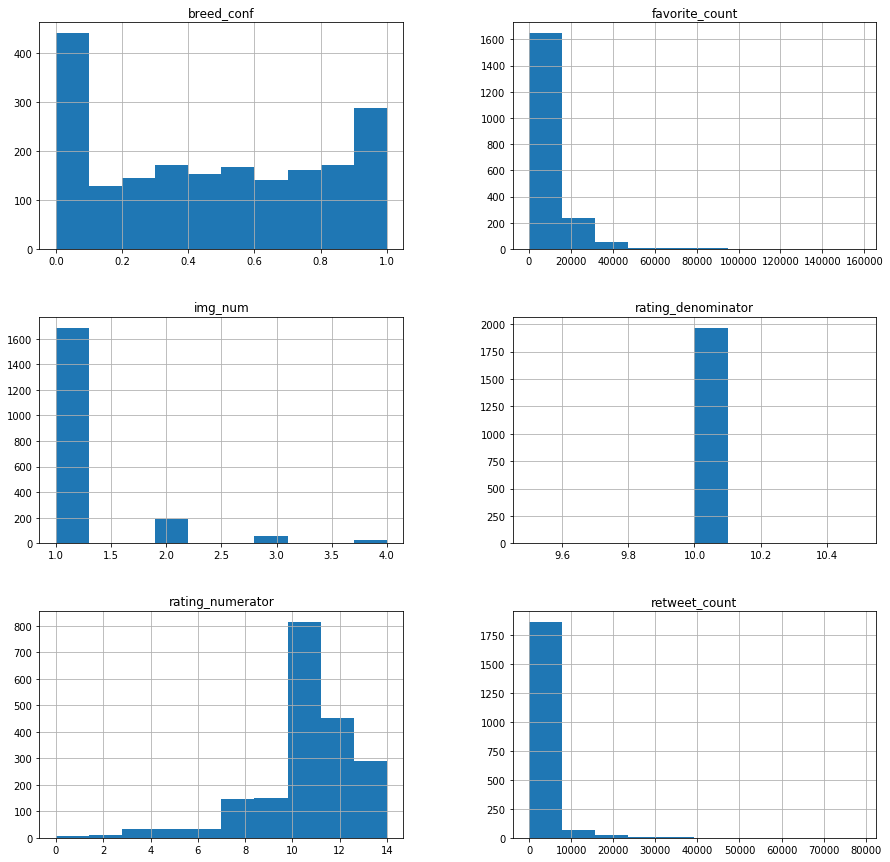

In [34]:
df.hist(figsize = [15,15]);

Looking at above initial data we can make some preliminary observations :

- Most number of tweets lie in 0 to 20K favorite count
- Most number of tweets lie in 0 to 10K retweet count
- Most number of tweets have only one image.
- Most dogs are rated between 8 and 14 (we eliminated some outliers)

Lets make some more deeper analysis on each column(s).

#### Q: What are the most popular breeds by Number of tweets ?

In [35]:
df.breed.value_counts().head(10)

Unknown               304
golden_retriever      156
Labrador_retriever    103
Pembroke              96 
Chihuahua             90 
pug                   63 
chow                  51 
toy_poodle            49 
Samoyed               42 
Pomeranian            40 
Name: breed, dtype: int64

Lets remove the Unknown breed and plot a graph to see the data better.

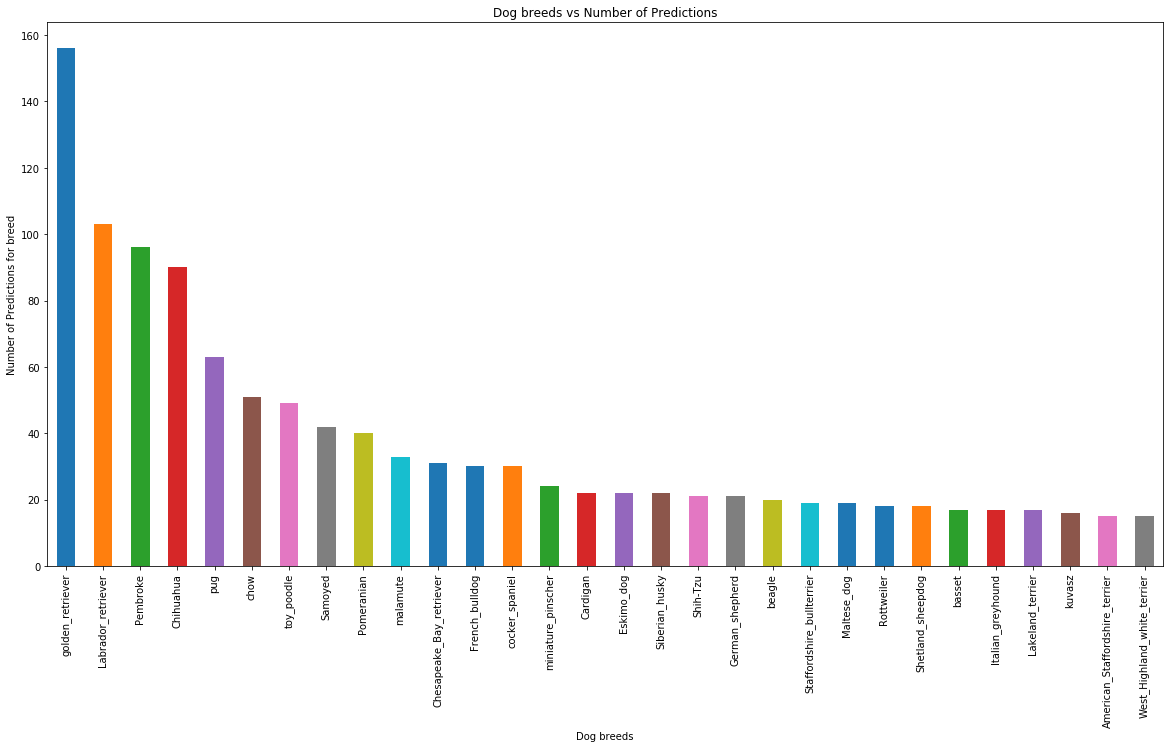

In [36]:
breeds = df[df['breed'] != 'Unknown'].breed
breeds.value_counts().nlargest(30).plot.bar(figsize = [20, 10])
plt.xlabel("Dog breeds")
plt.ylabel("Number of Predictions for breed")
plt.title("Dog breeds vs Number of Predictions");

From the above graph we can see that retrievers are the top two breeds followed by Pembroke, Chihuahua and pug. 

#### Q : Popular dog by rating average ?

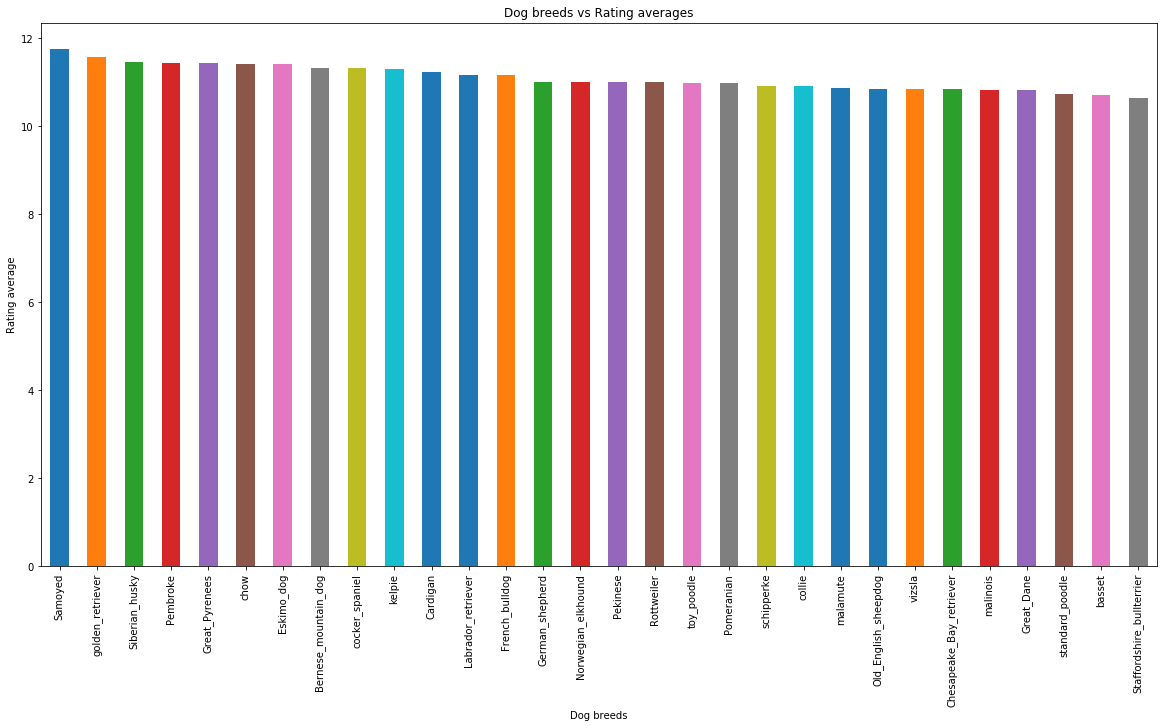

In [37]:
# Filter out the breeds that have less than 10 entries
t = df.query("breed != 'Unknown'").groupby(by="breed").filter(lambda x: len(x) > 10)

# Use the filtered breeds to see the trend of rating amongst them
t.groupby(by="breed")['rating_numerator'].mean().sort_values(ascending=False).head(30).plot.bar(figsize = [20, 10]);
plt.xlabel("Dog breeds")
plt.ylabel("Rating average")
plt.title("Dog breeds vs Rating averages");

The above bar has Golden retriever and Pembroke amongst top 5 that were also present in the top 5 when ordered by number of images.

#### Q : What are dog stage distributions ?

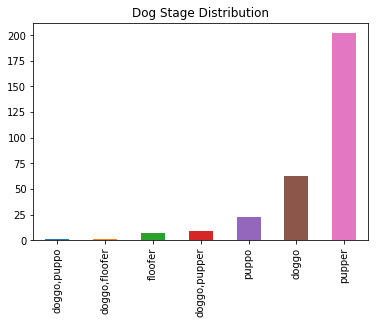

In [38]:
df.dog_type.value_counts().nsmallest(7).plot.bar(title="Dog Stage Distribution");

Looking at above graph, we can see that puppers are most common stage of the dog. This may be because most number of tweets are from people excited about their new pups and posting multiple pics on social media during early stages of their dog's growth.

#### Q : What is the most common source for posting tweets ?

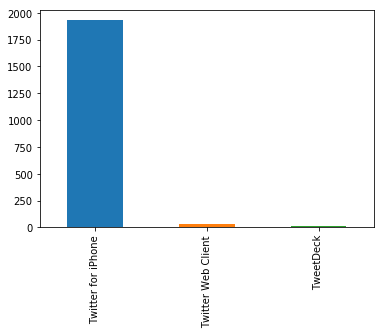

In [39]:
df.source.value_counts().plot.bar();

This reveals an interesting statistic that the User (or users ?) handle of we rate dogs definitely uses the twitter app for iPhone for posting most number of the tweets. More interestingly, there was a fourth source in the initial dataset given to us which completeley disappeared after cleaning our dataset. This may be because the other source (`Vine - Make a Scene` - which had 91 tweets) could be coming from retweets and such. 